# Introduction to forward-modelling: TRF
The Temporal Response Function is a generalization of ERP to continuous stimuli/signals. In summary, it is a linear spatio-temporal filter that allows to map one stimuli over electrophysiological data. Alternatively, it can be described as an impulse function, considering the brain (or at least the potential generating process) as a linear time invariant system for the considered stimuli. This model is described as "forward" because we map a stimuli onto neural data, thus following a causal direction. Obviously, this notion could be generalized to other processes where the causal relationship is not as clear, but for simplicity sake, we will only describe the example of sensory processing.

The main advantages of the TRF are that it is multivariate: it can take into account multiple regressor/stimuli and combine them, as well as multiple timelags, it is fast (at least as computed in this package) and it is linear and, therefore, easily explainable. This also implies that it cannot capture non-linearity by itself, but this is mitigated by the ability to use non-linear regressors.



## Importing the library

First, we install the necessary libraries. The spyeeg library contains utility functions that may be useful but most functions relevant to neuroscientists are located in "models", so let's import this one!

In [2]:
%load_ext autoreload
%autoreload 2

# Spyeeg import
import spyeeg.models as models
from spyeeg.generate import simulate_channels, simulate_multisensory_channels

# Other useful imports
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.signal as signal
from sklearn.preprocessing import scale
from scipy.signal import convolve
from sklearn.preprocessing import MinMaxScaler
import colorednoise as cn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Let's Generate a simple example

To make things simpler, we will create a set of data to vizualize what the TRF package does easily

(0.0, 30.0)

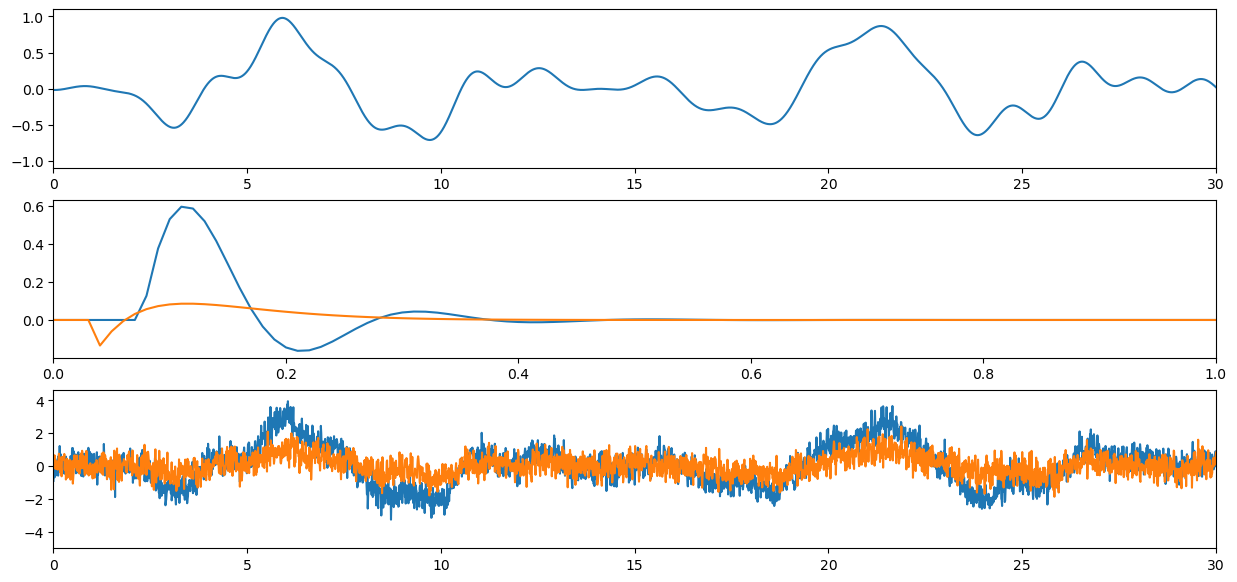

In [41]:
fs = 100
n_feat = 1
n_channels = 2
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = T * 10, 
                                                              impulse_freqs = [1,10], decreasing_rates = [10,25], delays = [0.03,0.1],
                                                              compression_factor = 1, 
                                                              noise_level = 0.5, beta_noise = 0.4, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 0, scale_data = False)

fig, ax = plt.subplots(3,figsize = (15,7), sharex = False)
ax[0].plot(time_array,X)
for i in range(n_feat):
    for j in range(n_channels):
        ax[1].plot(time_array,impulse_responses[i,j])
ax[2].plot(time_array,Y)
ax[0].set_xlim([0,30])
ax[1].set_xlim([0,1])
ax[2].set_xlim([0,30])

In [1018]:
tmin = -0.3
tmax = 0.7
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0])
X = stimuli_pos
Y = electrophysiological_data

trf.fit(X, Y)
scores = trf.scores

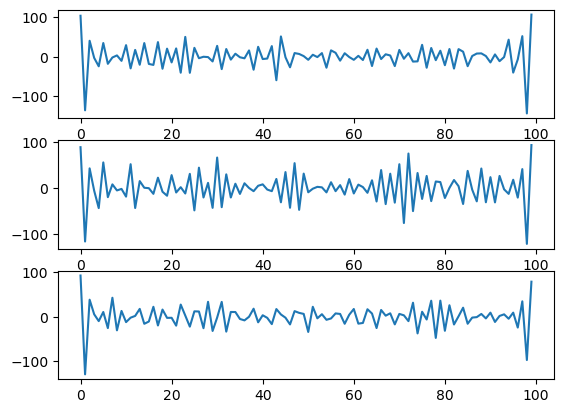

In [795]:
coefficients = trf.get_coef()
fig, ax = plt.subplots(coefficients.shape[2])
for i in range(coefficients.shape[2]):
    ax[i].plot(coefficients[:,0,i,0])

## Effect of Regularization

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


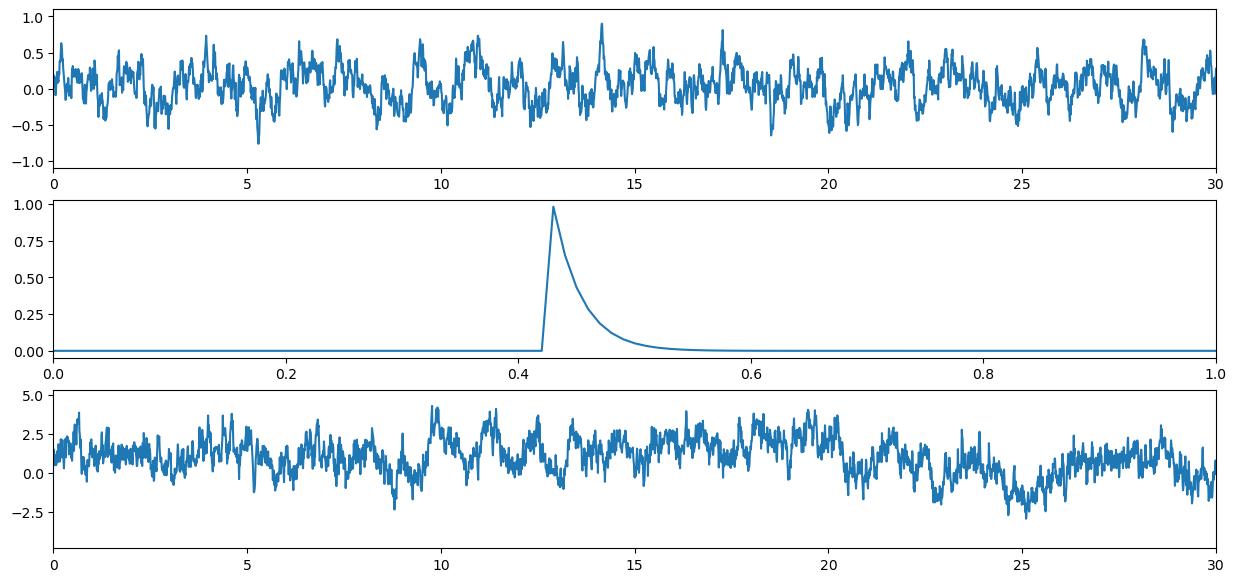

In [47]:
fs = 100
n_feat = 1
n_channels = 1
T = 600


time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = T * 10, 
                                                              impulse_freqs = [1,10], decreasing_rates = [40,45], delays = [0.2,0.5],
                                                              compression_factor = 1, 
                                                              noise_level = 1, beta_noise = 1, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 0, scale_data = False)
fig, ax = plt.subplots(3,figsize = (15,7), sharex = False)
ax[0].plot(time_array,X)
for i in range(n_feat):
    for j in range(n_channels):
        ax[1].plot(time_array,impulse_responses[i,j])
ax[2].plot(time_array,Y)
ax[0].set_xlim([0,30])
ax[1].set_xlim([0,1])
ax[2].set_xlim([0,30])


X,Y = scale(X), scale(Y)
tmin = -1
tmax = 1
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,10,20))
scores = trf.xval_eval(X, Y, scoring = 'R2')

Notice: kernels can have higher values because noise adds power. Make a comparison between white and pink noise. Make two different signals for input and compare decoding...etc
Note about R2 and corr: R2 does not mean anything

(0.0, 1.0)

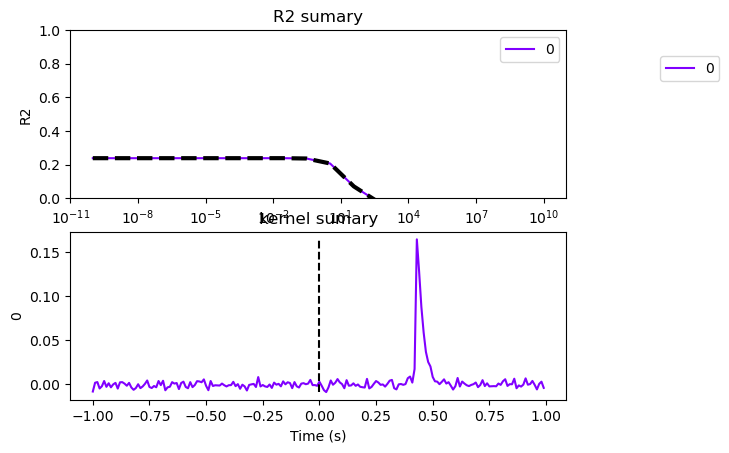

In [48]:
fig, ax = plt.subplots(2)

trf.plot_score(figax = (fig, ax[0]),minR2 = 0)
trf.plot_kernel(figax = (fig, ax[1]),minR2 = 0)
ax[0].set_ylim(0,1)

## Multivariate Analysis

In [98]:
fs = 100
n_feat = 2
n_channels = 10
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = T * 10, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.05],
                                                              compression_factor = 1, 
                                                              noise_level = 0.5, beta_noise = 0.4, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 10, scale_data = False)
X,Y = scale(X), scale(Y)


In [99]:
tmin = -0.1
tmax = .3
trf1 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-1,5,20))
scores1 = trf1.xval_eval(X[:,0:1], Y, scoring = 'R2').mean(0).max(-1)

trf2 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-1,5,20))
scores2 = trf2.xval_eval(X[:,1:2], Y, scoring = 'R2').mean(0).max(-1)

trf12 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-1,5,20))
scores12 = trf12.xval_eval(X[:,:], Y, scoring = 'R2').mean(0).max(-1)

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


{'whiskers': [<matplotlib.lines.Line2D at 0x168a92ba0>,
 'caps': [<matplotlib.lines.Line2D at 0x168a90710>,
 'boxes': [<matplotlib.lines.Line2D at 0x168a90ec0>,
 'medians': [<matplotlib.lines.Line2D at 0x168a90950>,
 'fliers': [<matplotlib.lines.Line2D at 0x169272d80>,
 'means': []}

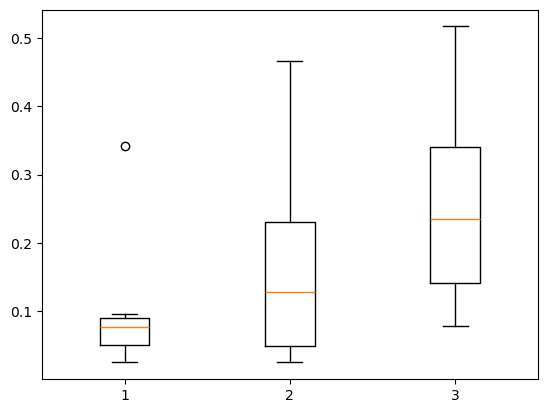

In [100]:
fig, ax = plt.subplots()

ax.boxplot(np.asarray([scores1,scores2,scores12]).T)

(<Figure size 640x480 with 9 Axes>,
 array([<Axes: title={'center': 'kernel sumary'}, xlabel='Time (s)', ylabel='0'>,
        <Axes: xlabel='Time (s)', ylabel='1'>], dtype=object))

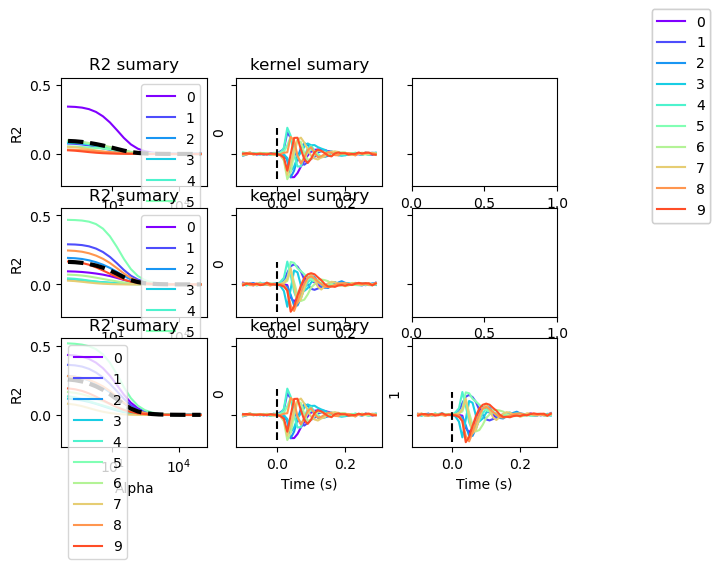

In [102]:
fig, ax = plt.subplots(3,3, sharey = True)
trf1.plot_score(figax = (fig, ax[0,0]))
trf1.plot_kernel(figax = (fig, ax[0,1]))
trf2.plot_score(figax = (fig, ax[1,0]))
trf2.plot_kernel(figax = (fig, ax[1,1]))
trf12.plot_score(figax = (fig, ax[2,0]))
trf12.plot_kernel(figax = (fig, ax[2,1:]))

## Correlated Stimuli and partial explained variance

Let's take the example of 2 features that VERY correlated (i.e. they're the same). Reasonning using coefficients set to 0 yields score because of how the kernels are being 'shared'. Therefore it is not a proper manner to segment their explained variance. Worse, they end up with exactly the same correlation...

In [32]:
fs = 100
n_feat = 1
n_channels = 1
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = T * 10, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.05],
                                                              compression_factor = 1, 
                                                              noise_level = 0.5, beta_noise = 0.4, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 10, scale_data = False)
X,Y = scale(X), scale(Y)
X2 = np.hstack([X,X])

In [64]:
tmin = -0.1
tmax = .3
trf1 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-1,5,20))
scores1 = trf1.xval_eval(X, Y, scoring = 'R2').mean(0).max(-1)

trf2 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-1,5,20))
scores2 = trf2.xval_eval(X2, Y, scoring = 'R2').mean(0).max(-1)


Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


(<Figure size 640x480 with 6 Axes>,
 array([<Axes: title={'center': 'kernel sumary'}, xlabel='Time (s)', ylabel='0'>,
        <Axes: xlabel='Time (s)', ylabel='1'>], dtype=object))

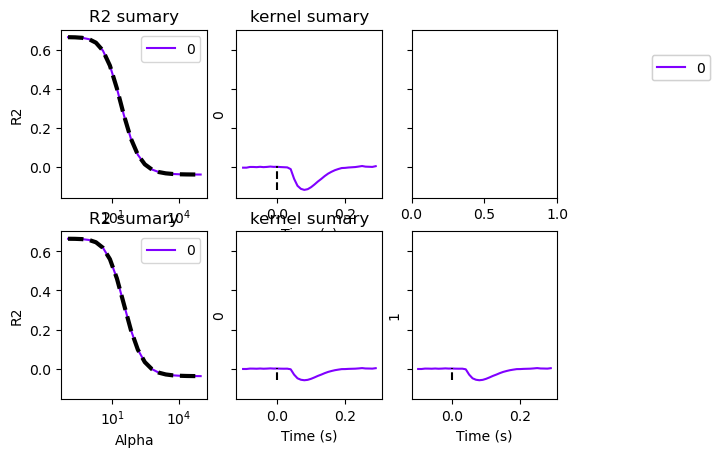

In [65]:
fig, ax = plt.subplots(2,3, sharey = True)
trf1.plot_score(figax = (fig, ax[0,0]))
trf1.plot_kernel(figax = (fig, ax[0,1]))
trf2.plot_score(figax = (fig, ax[1,0]))
trf2.plot_kernel(figax = (fig, ax[1,1:]))

In [66]:
from spyeeg.models._methods import _r2_multifeat, _corr_multifeat

scoring_func = _r2_multifeat
yhat = trf2.predict(X2)
print(scoring_func(yhat[:,:,0],Y))
coef = trf2.coef_.reshape(40,2,1,20)
coef[:,0,:,:] = 0
coef = coef.reshape(80,1,20) 
trf2.coef_ = coef
yhat = trf2.predict(X2)
print(scoring_func(yhat[:,:,0],Y))

[0.67832009]
[0.50592681]


## On variance partitioning

In [92]:
from spyeeg.generate import simulate_continuous_stimuli

fs = 100
n_feat = 2
n_channels = 1
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = T * 10, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.05],
                                                              compression_factor = 1, 
                                                              noise_level = 0.5, beta_noise = 0.4, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 10, scale_data = False)
X_noise = simulate_continuous_stimuli(fs,time_array)
X = np.hstack([X, X_noise[:,np.newaxis]])
X,Y = scale(X), scale(Y)

In [93]:
tmin = -0.1
tmax = .3
alpha = [0] + np.logspace(-5,5,20)
metrics = 'R2'
trf1 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = alpha)
scores1 = trf1.xval_eval(X[:,:1], Y, scoring = metrics).mean(0).max(-1)

trf2 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = alpha)
scores2 = trf2.xval_eval(X[:,:2], Y, scoring = metrics).mean(0).max(-1)

trf12 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = alpha)
scores12 = trf12.xval_eval(X[:,:3], Y, scoring = metrics).mean(0).max(-1)

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


(<Figure size 640x480 with 12 Axes>,
 array([<Axes: title={'center': 'kernel sumary'}, xlabel='Time (s)', ylabel='0'>,
        <Axes: xlabel='Time (s)', ylabel='1'>,
        <Axes: xlabel='Time (s)', ylabel='2'>], dtype=object))

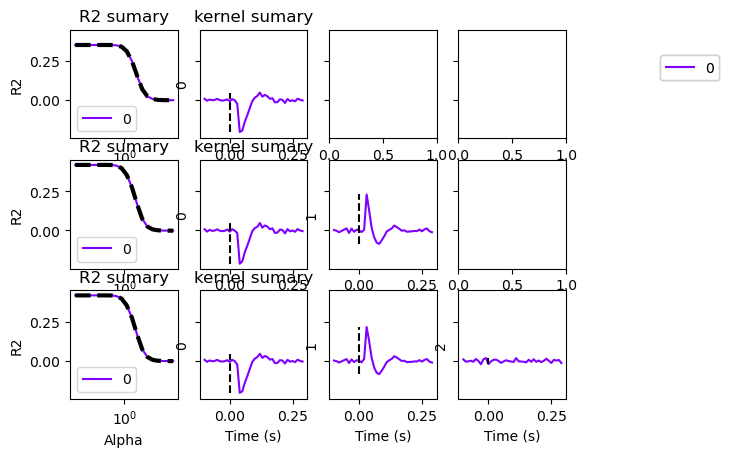

In [94]:
fig, ax = plt.subplots(3,4, sharey = True)
trf1.plot_score(figax = (fig, ax[0,0]))
trf1.plot_kernel(figax = (fig, ax[0,1]))
trf2.plot_score(figax = (fig, ax[1,0]))
trf2.plot_kernel(figax = (fig, ax[1,1:3]))
trf12.plot_score(figax = (fig, ax[2,0]))
trf12.plot_kernel(figax = (fig, ax[2,1:]))

## Metrics

In [1022]:
tmin = -0.1
tmax = 0.5
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-5,5,20))

X = scale(X)
Y = scale(Y)

import time
start = time.time()
print(time.time() - start)
scores = trf.xval_eval(X, Y, scoring = 'ezekiel')
print(time.time() - start)

3.2901763916015625e-05
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
0.7067599296569824


(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'R2 sumary'}, xlabel='Alpha', ylabel='R2'>)

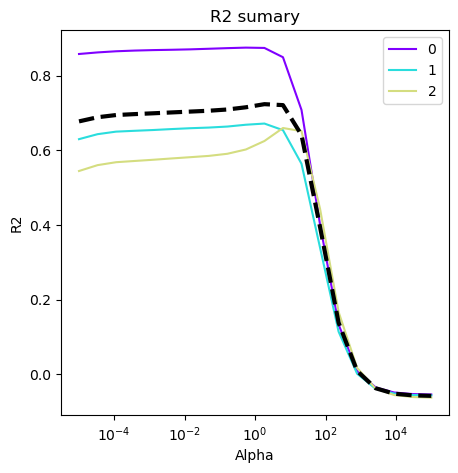

In [1023]:
trf.plot_score()

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'R2 sumary'}, xlabel='Alpha', ylabel='R2'>)

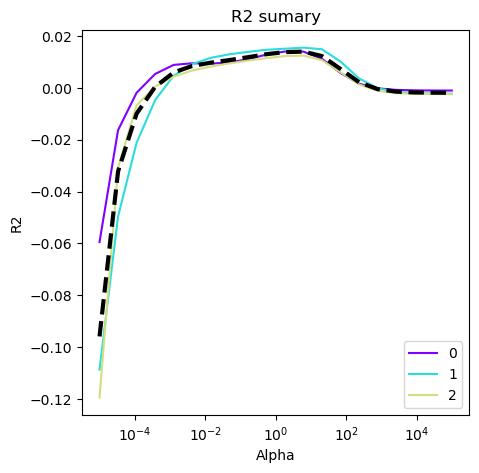

In [979]:
trf.plot_score()

## More is not always better

#### More time lags -> more noise is capted -> possible overfitting

In [423]:
fs = 100
n_feat = 1
n_channels = 50
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = T * 10, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.05],
                                                              compression_factor = 1, 
                                                              noise_level = 0.5, beta_noise = 1, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 10, scale_data = True)

In [425]:
trf_short = models.TRF.TRFEstimator(tmin=0, tmax=0.07, srate = fs, alpha = [0] + np.logspace(-10,5,20))
scores_short = trf_short.xval_eval(X, Y, scoring = 'R2').mean(0).max(-1)

trf_med = models.TRF.TRFEstimator(tmin=-0.1, tmax=0.3, srate = fs, alpha = [0] + np.logspace(-10,5,20))
scores_med = trf_med.xval_eval(X, Y, scoring = 'R2').mean(0).max(-1)

trf_long = models.TRF.TRFEstimator(tmin=-2, tmax=2, srate = fs, alpha = [0] + np.logspace(-10,5,20))
scores_long = trf_long.xval_eval(X, Y, scoring = 'R2').mean(0).max(-1)



Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


{'whiskers': [<matplotlib.lines.Line2D at 0x16bf5d610>,
 'caps': [<matplotlib.lines.Line2D at 0x16bf5dbb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x16bf5d370>,
 'medians': [<matplotlib.lines.Line2D at 0x16bf5e0c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x16bf5e330>,
 'means': []}

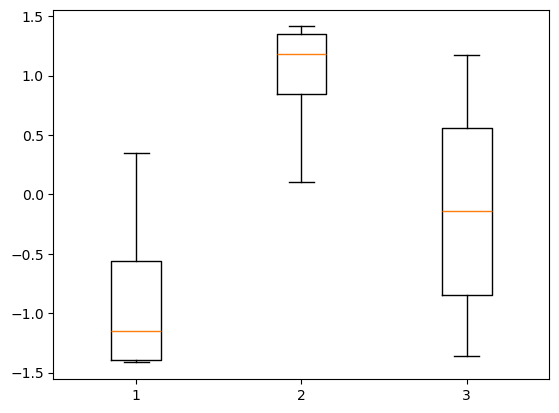

In [128]:
'''
fig, ax = plt.subplots(1,3, sharex = True, figsize = (10,2))
trf_short.plot_kernel(figax = (fig, ax[0]))
trf_med.plot_kernel(figax = (fig, ax[1]))
trf_long.plot_kernel(figax = (fig, ax[2]))

fig, ax = plt.subplots(1,3, sharex = True, figsize = (10,2), sharey = True)
trf_short.plot_score(figax = (fig, ax[0]))
trf_med.plot_score(figax = (fig, ax[1]))
trf_long.plot_score(figax = (fig, ax[2]))
ax[0].set_ylim([0,0.5])
'''
plt.boxplot(scale(np.vstack([scores_short, scores_med, scores_long]).T,axis=1))

#### Out of Sample R2 is a negatively biased estimator -> adding too many features is detrimental

In [134]:
from spyeeg.feat import permut_discrete

fs = 100
n_feat = 1
n_channels = 50
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'discrete', n_pulse = T * 10, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.05],
                                                              compression_factor = 1, 
                                                              noise_level = 0.5, beta_noise = 0.4, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 10, scale_data = True)
random_peaks1 = permut_discrete(X)
random_peaks2 = permut_discrete(X)
X_noise1 = np.hstack([X, random_peaks1])
X_noise2 = np.hstack([X, random_peaks1, random_peaks2])
X_noise1,X_noise2 = scale(X_noise1),scale(X_noise2)

In [135]:
tmin, tmax = 0,0.3

trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,5,20))
scores = trf.xval_eval(X, Y, scoring = 'R2').mean(0).max(-1)

trf_noise1 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,5,20))
scores_noise1 = trf_noise1.xval_eval(X_noise1, Y, scoring = 'R2').mean(0).max(-1)

trf_noise2 = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,5,20))
scores_noise2 = trf_noise2.xval_eval(X_noise2, Y, scoring = 'R2').mean(0).max(-1)

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


[-0.01571429 -0.00313676 -0.01750884 -0.05182671 -0.0397705  -0.0428325
 -0.01500601 -0.03540021 -0.02490942 -0.03327013 -0.03241306 -0.03462315
 -0.03416202 -0.01990993 -0.01351874 -0.03072139 -0.00850633 -0.01954416
 -0.03609906 -0.03819371 -0.03453822 -0.00469381 -0.02780457 -0.02676793
 -0.03373526 -0.02265765 -0.03233023 -0.02061963 -0.0348551  -0.00842355
 -0.04596827 -0.00018295 -0.01763759 -0.02005983 -0.03154523 -0.02932702
 -0.03250229 -0.02043242 -0.02674408 -0.05790633 -0.02070612 -0.03392123
 -0.01761234 -0.01687054 -0.06196051 -0.04396597 -0.03958902 -0.03771596
 -0.00685372 -0.02266067]


{'whiskers': [<matplotlib.lines.Line2D at 0x16c161fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x16c162510>,
 'boxes': [<matplotlib.lines.Line2D at 0x16c161d30>,
 'medians': [<matplotlib.lines.Line2D at 0x16c162990>,
 'fliers': [<matplotlib.lines.Line2D at 0x16c162c60>,
 'means': []}

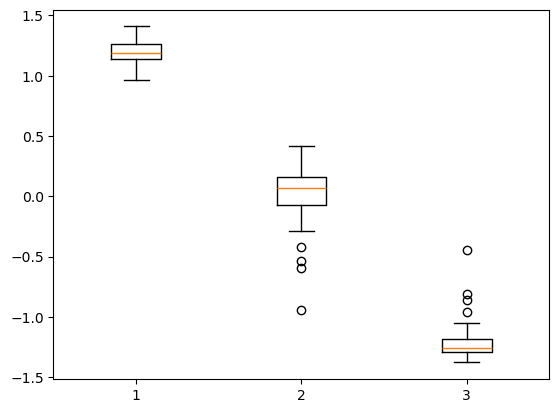

In [136]:
'''
fig, ax = plt.subplots(1,2, sharex = True, figsize = (10,2), sharey = True)
trf.plot_score(figax = (fig, ax[0]))
trf_noise.plot_score(figax = (fig, ax[1]))
ax[0].set_ylim([0,0.1])
'''
print(scores - scores_noise)
plt.boxplot(scale(np.vstack([scores, scores_noise1, scores_noise2]).T,axis=1))

#### Some corrections exist

In [2164]:
tmin, tmax = 0,0.3

trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,5,20))
scores = trf.xval_eval(X, Y, scoring = 'adj_R2').mean(0).max()

trf_noise = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,5,20))
scores_noise = trf_noise.xval_eval(X_noise, Y, scoring = 'adj_R2').mean(0).max()

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


0.0004592275038140872


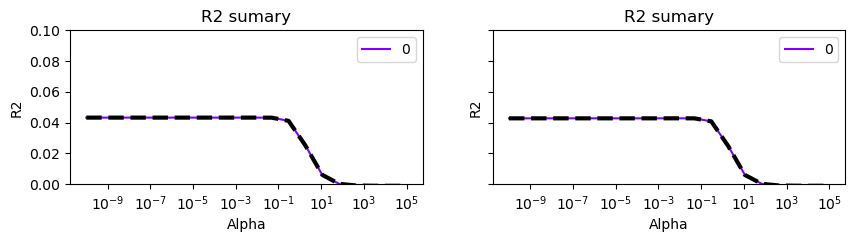

In [2165]:
fig, ax = plt.subplots(1,2, sharex = True, figsize = (10,2), sharey = True)
trf.plot_score(figax = (fig, ax[0]))
trf_noise.plot_score(figax = (fig, ax[1]))
ax[0].set_ylim([0,0.1])
print(scores - scores_noise)

# iRRR

In [493]:
%load_ext autoreload
%autoreload 2

# Spyeeg import
import spyeeg.models as models

# Other useful imports
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.signal as signal
from sklearn.preprocessing import scale
from scipy.signal import convolve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [494]:
tmin = -0.1
tmax = 0.5
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-2,2,5))
irrr = models.iRRR.iRRREstimator(tmin=tmin, tmax=tmax, srate = fs, lambda0 = np.logspace(-2,2,5), lambda1 = np.logspace(-2,2,5))

X = scale(X)
Y = scale(Y)

scores = trf.xval_eval(X, Y, scoring = 'R2')
scores_iRRR = irrr.xval_eval(X, Y, scoring = 'R2')

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5


In [495]:
scores.mean(0).max(1)

array([0.88854053, 0.989835  , 0.98409402])

In [496]:
scores_iRRR.mean(0).max((1,2))

array([-0.00022738,  0.00074596, -0.00066178])

(<Figure size 1500x800 with 2 Axes>,
 array([<Axes: title={'center': 'kernel sumary'}, xlabel='Time (s)', ylabel='0'>,
        <Axes: xlabel='Time (s)', ylabel='1'>], dtype=object))

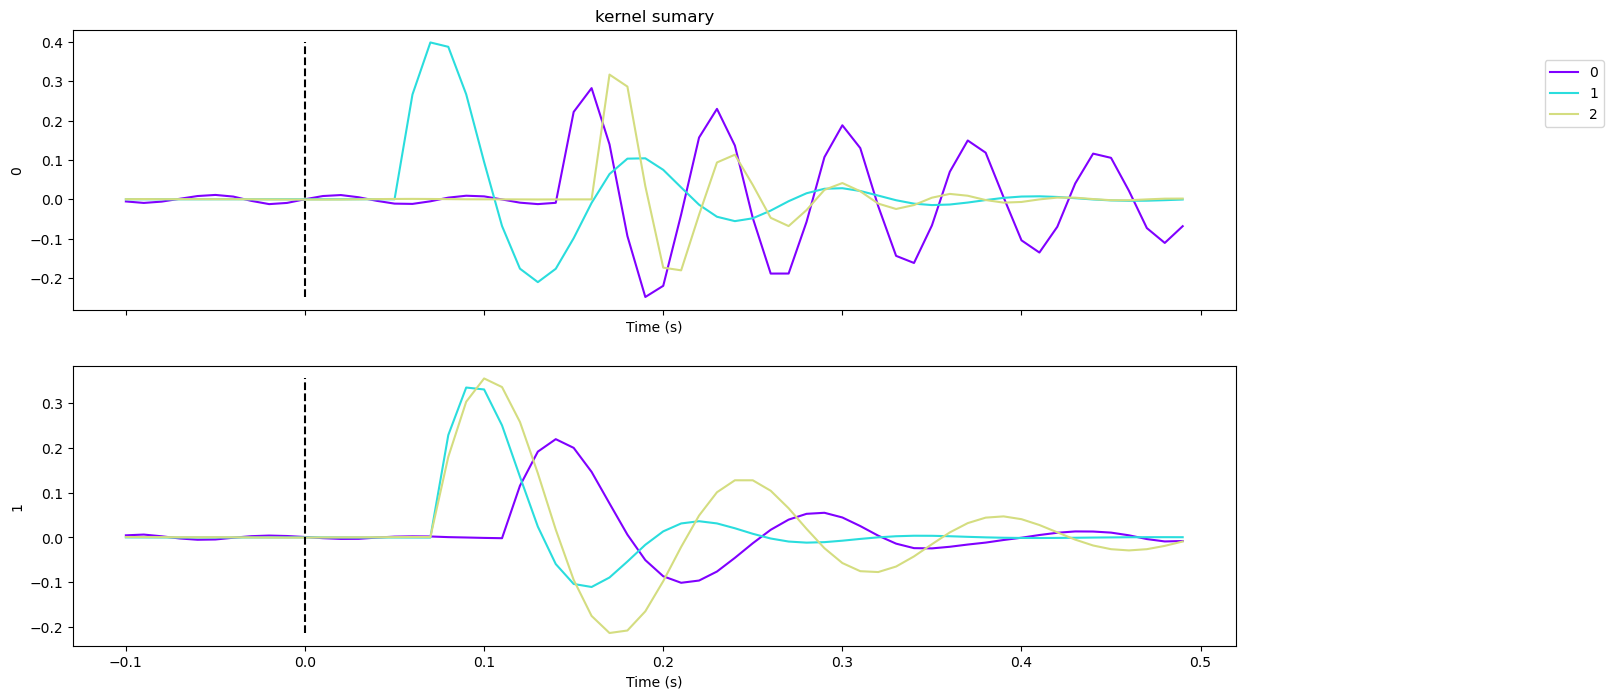

In [497]:
trf.plot_kernel()

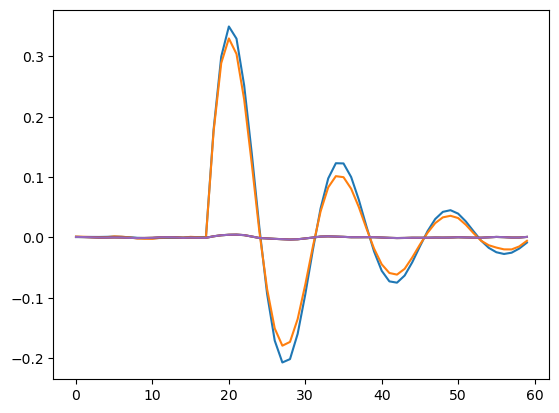

In [498]:
for i in range(5):
    plt.plot(np.asarray(irrr.get_coef())[0,:,1,2,0,i])


# ERP object

In [499]:
%load_ext autoreload
%autoreload 2

# Spyeeg import
import spyeeg.models as models

# Other useful imports
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.signal as signal
from sklearn.preprocessing import scale
from scipy.signal import convolve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'ERP'}, xlabel='Time (s)', ylabel='ERP (V)'>)

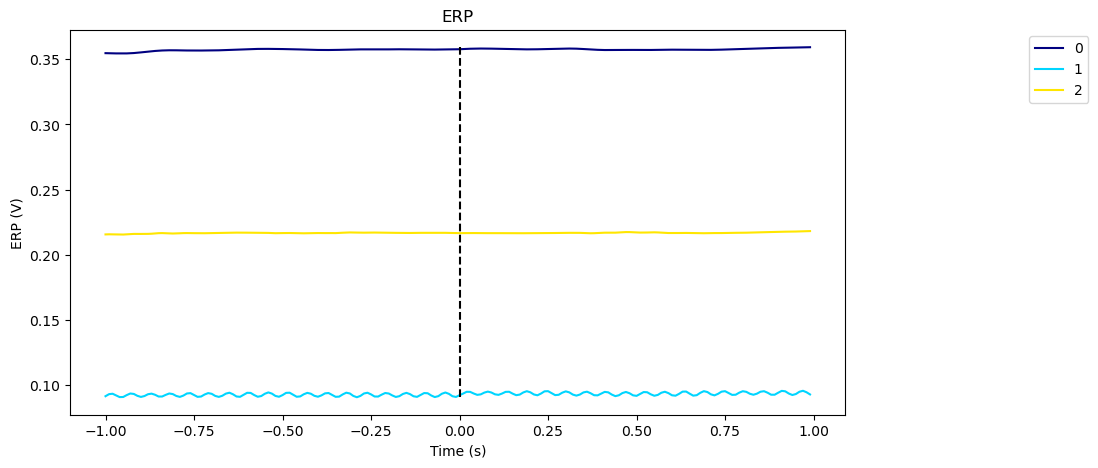

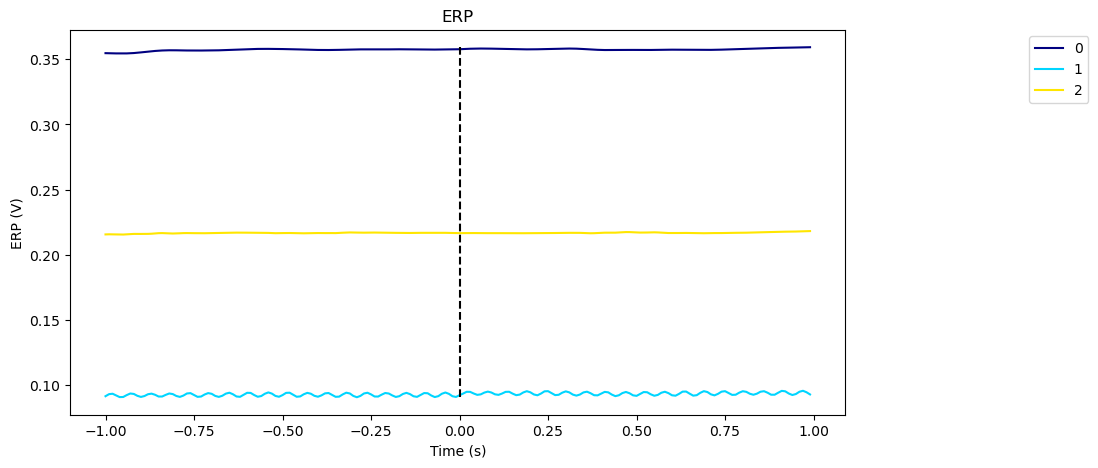

In [503]:
tmin, tmax = -1,1
X = scale(X, with_mean = False, with_std = False)
Y = scale(Y, with_mean = False, with_std = False)

erp1 = models.ERP.ERP_class(tmin, tmax, fs)
erp1.add_continuous_signal(Y, X[:,0], step = 1, weight_events = False)
erp2 = models.ERP.ERP_class(tmin, tmax, fs)
erp2.add_continuous_signal(Y, X[:,1], step = 1, weight_events = False)
erp1.plot_ERP()
erp2.plot_ERP()

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'ERP'}, xlabel='Time (s)', ylabel='ERP (V)'>)

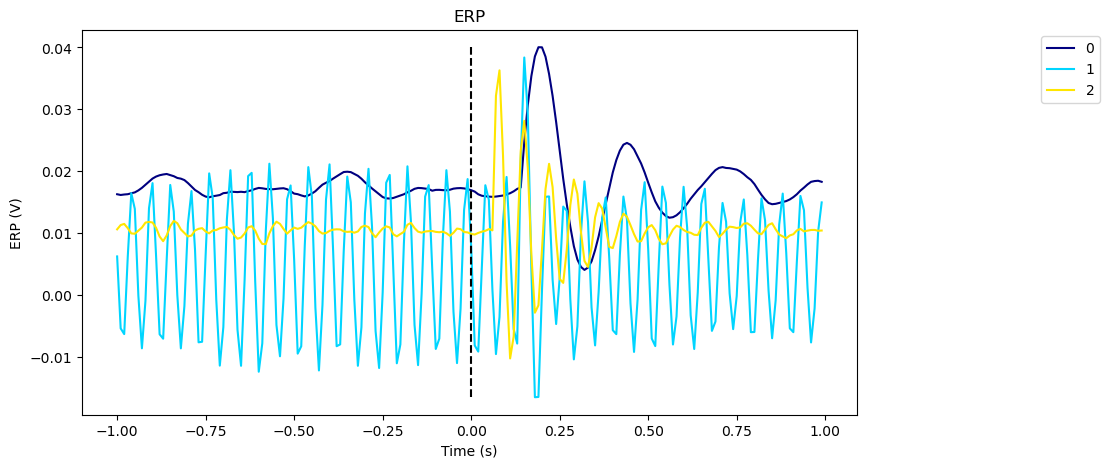

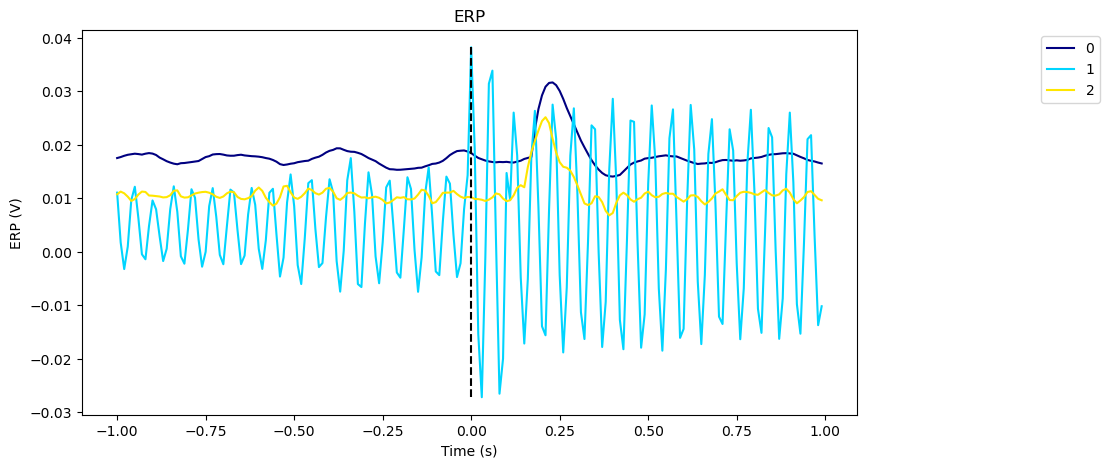

In [504]:
erp1 = models.ERP.ERP_class(tmin, tmax, fs)
erp1.add_continuous_signal(Y, X[:,0], step = 1, weight_events = True)
erp2 = models.ERP.ERP_class(tmin, tmax, fs)
erp2.add_continuous_signal(Y, X[:,1], step = 1, weight_events = True)
erp1.plot_ERP()
erp2.plot_ERP()

# b2b

In [1245]:
%load_ext autoreload
%autoreload 2

# Spyeeg import
import spyeeg.models as models

# Other useful imports
import numpy as np
import matplotlib.pyplot as plt
import mne
import scipy.signal as signal
from sklearn.preprocessing import scale
from scipy.signal import convolve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
from spyeeg.models.rERP import ERPEstimator

fs = 100
n_feat = 2
n_channels = 2
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = T, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.05],
                                                              compression_factor = 1, 
                                                              noise_level = 0, beta_noise = 1, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 0, scale_data = False)

In [123]:
from spyeeg.models.B2B import B2BEstimator

tmin, tmax = -.1, .3
b2b = B2BEstimator(tmin, tmax, srate = fs)
S = b2b.xval_eval(X,Y)


Computing fold 1 / 100
Computing fold 11 / 100
Computing fold 21 / 100
Computing fold 31 / 100
Computing fold 41 / 100
Computing fold 51 / 100
Computing fold 61 / 100
Computing fold 71 / 100
Computing fold 81 / 100
Computing fold 91 / 100


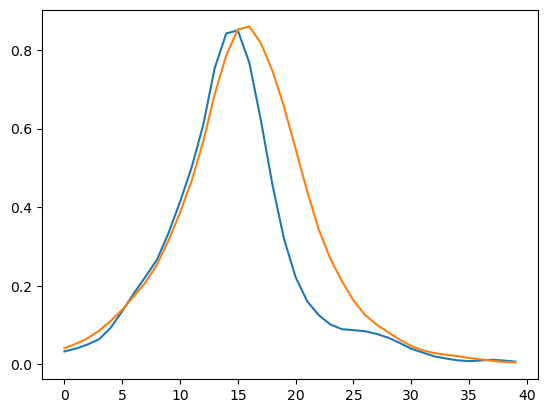

In [128]:
plt.plot(S.mean(0))

# ESN

In [41]:
fs = 100
n_feat = 1
n_channels = 1
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = T * 10, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.05],
                                                              compression_factor = 1, 
                                                              noise_level = 0.5, beta_noise = 0.4, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 10, scale_data = False)
X,Y = scale(X), scale(Y)

In [42]:
import reservoirpy
from spyeeg.models.ESN import ESNEstimator
from sklearn.model_selection import train_test_split

tmin, tmax = -0.05,0.3
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,5,20))
scores_trf = trf.xval_eval(X, Y, scoring = 'R2')
scores_trf = scores_trf.mean(0).max(-1)

esn = ESNEstimator(srate = fs, alpha = np.logspace(-15,5,40), n_units = 100, 
                   percentile_units = 0, reservoir_mode = 'separate', scale_reservoir = False,
                  lr = 0.4, sr = .9)
scores_esn = esn.xval_eval(X,Y)
scores_esn = scores_esn.mean(0).max(-1)

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


[-0.00456168]


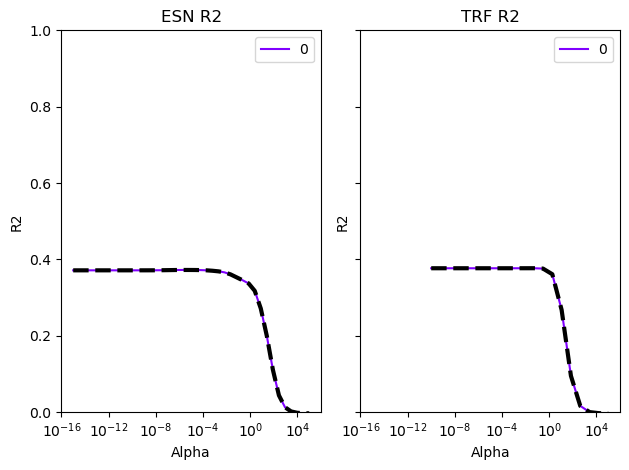

In [44]:
fig, ax = plt.subplots(1,2, sharey = True, sharex = True)
esn.plot_score(figax = (fig, ax[0]))
trf.plot_score(figax = (fig, ax[1]))
ax[0].set_ylim(0,1)

ax[0].set_title('ESN R2')
ax[1].set_title('TRF R2')
fig.tight_layout()
print(scores_esn - scores_trf)

In [5]:
fs = 100
n_feat = 1
n_channels = 1
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = T * 10, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.05],
                                                              compression_factor = 1/3, 
                                                              noise_level = 0.5, beta_noise = 1, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 10, scale_data = False)
X,Y = scale(X), scale(Y)

In [6]:
tmin, tmax = -0.05,0.3
trf = models.TRF.TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = [0] + np.logspace(-10,5,20))
scores_trf = trf.xval_eval(X, Y, scoring = 'R2')
scores_trf = scores_trf.mean(0).max(-1)

esn = ESNEstimator(srate = fs, alpha = np.logspace(-15,5,40), n_units = 100, 
                   percentile_units = 0, reservoir_mode = 'separate', scale_reservoir = False,
                  lr = 0.4, sr = .9)
scores_esn = esn.xval_eval(X,Y, scoring = 'R2')
scores_esn = scores_esn.mean(0).max(-1)

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


NameError: name 'ESNEstimator' is not defined

[0.04820577]


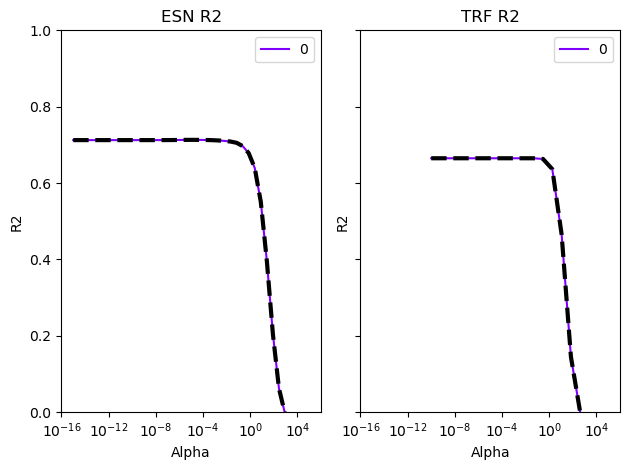

In [57]:
fig, ax = plt.subplots(1,2, sharey = True, sharex = True)
esn.plot_score(figax = (fig, ax[0]))
trf.plot_score(figax = (fig, ax[1]))
ax[0].set_ylim(0,1)

ax[0].set_title('ESN R2')
ax[1].set_title('TRF R2')
fig.tight_layout()
print(scores_esn - scores_trf)

# ERP regression

In [92]:
from spyeeg.models.rERP import ERPEstimator

fs = 100
n_feat = 2
n_channels = 1
T = 600
time_array, X, Y, events, impulse_responses = simulate_channels(n_feat = n_feat, n_channels = n_channels, fs = fs, T = T,  
                                                              stim_type = 'continuous', n_pulse = T, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.05],
                                                              compression_factor = 1, 
                                                              noise_level = 0, beta_noise = 1, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 0, scale_data = False)

In [105]:
tmin, tmax = 0, 0.3

erp = ERPEstimator(tmin = tmin, tmax = tmax, srate = fs, alpha = [0])
scores = erp.xval_eval(X,Y, drop_overlap = False, events_type= 'single',
                      scalex = False, scaley = False).mean(0)

(59971, 2)
(59971, 30)
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


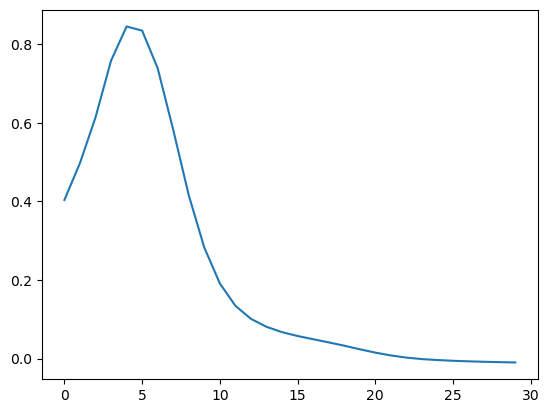

In [106]:
plt.plot(scores[:,:,0])

## TF: Frequency and PAC

## PCA Ridge

## Ridge

## Multisensory

#### Small Example with no supra-additive effect i.e. in the multisensory condition, the impulse response is just a sum of the unisensory response

(0.0, 10.0)

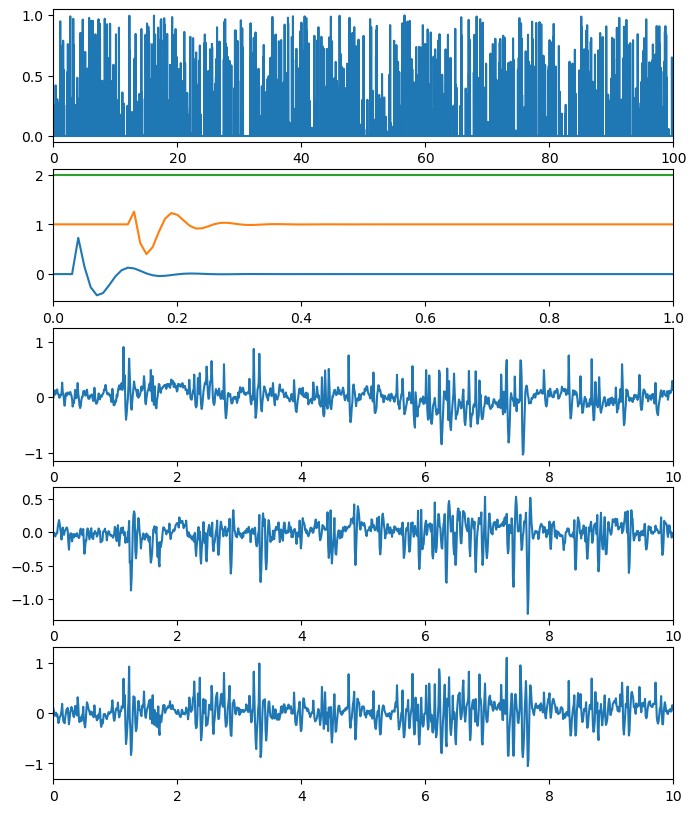

In [2216]:
fs = 100
n_feat = 1
n_channels = 1
T = 120

time_array, X, Y1,Y2,Y12, events, impulse_responses = simulate_multisensory_channels(n_feat = n_feat, n_channels = n_channels, 
                                                              fs = fs, T = T,  
                                                              stim_type = 'discrete', n_pulse = T * 8, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.2],
                                                              compression_factor = 1, 
                                                              noise_level = 0.1, beta_noise = 1, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 10, scale_data = False, supra_amp = 0)
fig, ax = plt.subplots(5,figsize = (8,10), sharex = False)
ax[0].plot(time_array,X)
for i in range(n_feat):
    for j in range(n_channels):
        for k in range(2):
            ax[1].plot(time_array,impulse_responses[k,i,j] + k, alpha = 1)
        ax[1].plot(time_array,impulse_responses[2,i,j] - impulse_responses[0,i,j] - impulse_responses[1,i,j] + 2, alpha = 1)
ax[2].plot(time_array,Y1)
ax[3].plot(time_array,Y2)
ax[4].plot(time_array,Y12)
ax[0].set_xlim([0,100])
ax[1].set_xlim([0,1])
ax[2].set_xlim([0,10])
ax[3].set_xlim([0,10])
ax[4].set_xlim([0,10])


In [2217]:
tmin, tmax = -1,1
metrics = 'R2'
from spyeeg.models.TRF import TRFEstimator
alpha = [0] + np.logspace(-3,3,20)
trf1 = TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = alpha)
scores1_trf = trf1.xval_eval(X, Y1, scoring = metrics)
scores1_trf = np.asarray([max(score,0) for score in scores1_trf.mean(0)[0]])

trf2 = TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = alpha)
scores2_trf = trf2.xval_eval(X, Y2, scoring = metrics)
scores2_trf = np.asarray([max(score,0) for score in scores2_trf.mean(0)[0]])

trf12 = TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = alpha)
scores12_trf = trf12.xval_eval(X, Y12, scoring = metrics)
scores12_trf = np.asarray([max(score,0) for score in scores12_trf.mean(0)[0]])

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


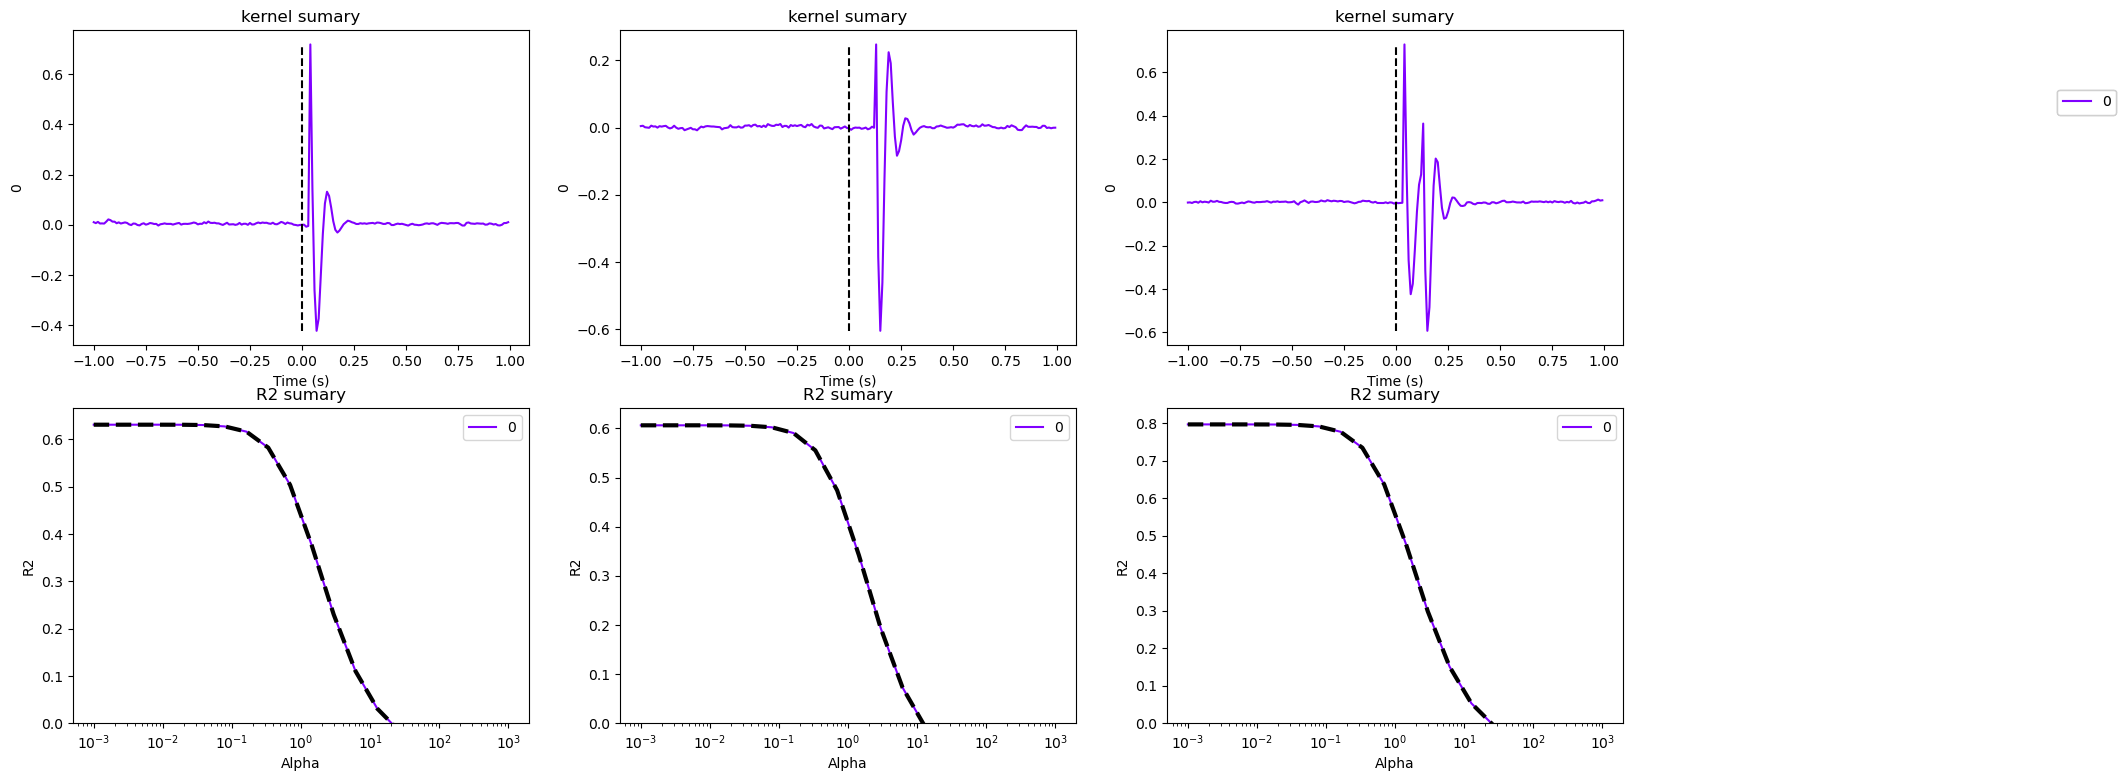

In [2218]:
fig, ax = plt.subplots(2,3, figsize = (20,9))
trf1.plot_kernel(figax = (fig, ax[0,0]))
trf2.plot_kernel(figax = (fig, ax[0,1]))
trf12.plot_kernel(figax = (fig, ax[0,2]))
trf1.plot_score(figax = (fig, ax[1,0]))
trf2.plot_score(figax = (fig, ax[1,1]))
trf12.plot_score(figax = (fig, ax[1,2]))
for i in range(3):
    ax[1,i].set_ylim([0,None])

Looking at the difference of kernels allows for interpretation. Careful with noise however, check that the topography makes sense!

(-1.0, 1.0)

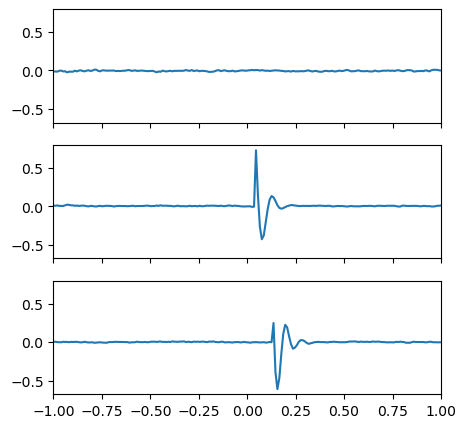

In [2219]:
fig,ax = plt.subplots(3,figsize = (5,5), sharey = True, sharex = True)

kernel_time = np.linspace(tmin, tmax,int((tmax-tmin)*fs))
alpha_kernel = int(np.mean([trf1.get_best_alpha(),trf2.get_best_alpha(),trf12.get_best_alpha()]))

ax[0].plot(kernel_time,scale((trf12.get_coef()[:,0,0,alpha_kernel] - trf1.get_coef()[:,0,0,alpha_kernel] - trf2.get_coef()[:,0,0,alpha_kernel]) ** 1, with_mean = False, with_std = False))
ax[1].plot(kernel_time,scale(trf1.get_coef()[:,0,0,alpha_kernel] ** 1, with_mean = False, with_std = False))
ax[2].plot(kernel_time,scale(trf2.get_coef()[:,0,0,alpha_kernel] ** 1, with_mean = False, with_std = False))
ax[0].set_xlim([-1,1])


The R2 can display supra-additive score despite no actual integration taking place!

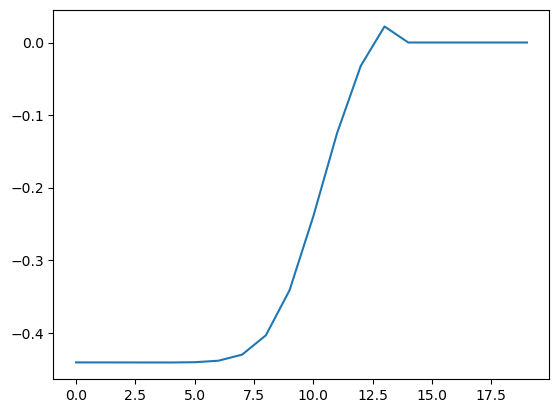

In [2220]:
plt.plot(scores12_trf - scores1_trf - scores2_trf)

#### Same but with actual multisensory activity

(0.0, 10.0)

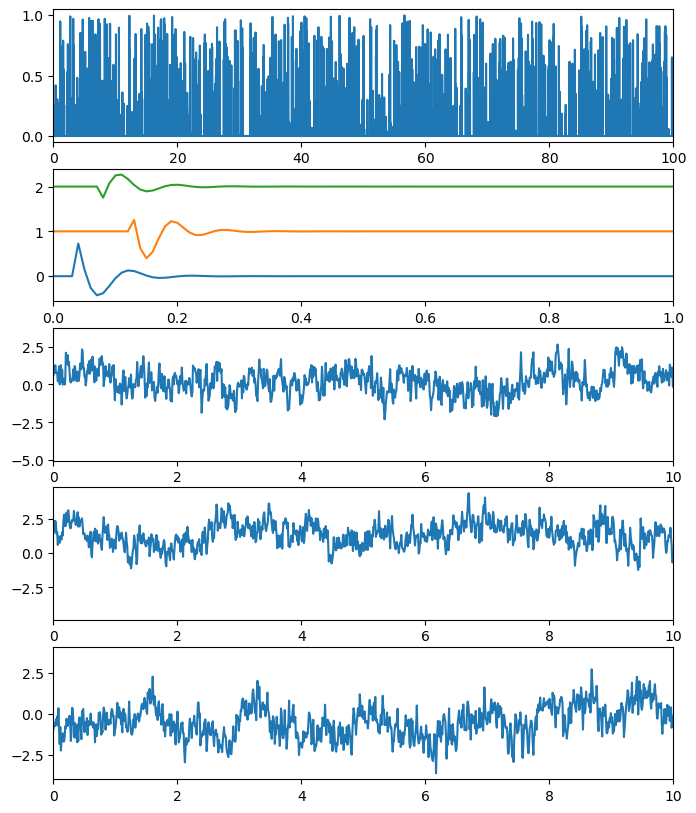

In [2246]:
fs = 100
n_feat = 1
n_channels = 1
T = 120

time_array, X, Y1,Y2,Y12, events, impulse_responses = simulate_multisensory_channels(n_feat = n_feat, n_channels = n_channels, 
                                                              fs = fs, T = T,  
                                                              stim_type = 'discrete', n_pulse = T * 8, 
                                                              impulse_freqs = [2,20], decreasing_rates = [20,25], delays = [0.03,0.2],
                                                              compression_factor = 1, 
                                                              noise_level = 1, beta_noise = 1, #0 = white, 1 = pink, 2 = red
                                                              random_seed = 10, scale_data = False, supra_amp = 0.5)
fig, ax = plt.subplots(5,figsize = (8,10), sharex = False)
ax[0].plot(time_array,X)
for i in range(n_feat):
    for j in range(n_channels):
        for k in range(2):
            ax[1].plot(time_array,impulse_responses[k,i,j] + k, alpha = 1)
        ax[1].plot(time_array,impulse_responses[2,i,j] - impulse_responses[0,i,j] - impulse_responses[1,i,j] + 2, alpha = 1)
ax[2].plot(time_array,Y1)
ax[3].plot(time_array,Y2)
ax[4].plot(time_array,Y12)
ax[0].set_xlim([0,100])
ax[1].set_xlim([0,1])
ax[2].set_xlim([0,10])
ax[3].set_xlim([0,10])
ax[4].set_xlim([0,10])


In [2247]:
tmin, tmax = -1,1
metrics = 'corr'
from spyeeg.models.TRF import TRFEstimator
alpha = [0] + np.logspace(-3,3,20)
trf1 = TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = alpha)
scores1_trf = trf1.xval_eval(X, Y1, scoring = metrics)
scores1_trf = np.asarray([max(score,0) for score in scores1_trf.mean(0)[0]])

trf2 = TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = alpha)
scores2_trf = trf2.xval_eval(X, Y2, scoring = metrics)
scores2_trf = np.asarray([max(score,0) for score in scores2_trf.mean(0)[0]])

trf12 = TRFEstimator(tmin=tmin, tmax=tmax, srate = fs, alpha = alpha)
scores12_trf = trf12.xval_eval(X, Y12, scoring = metrics)
scores12_trf = np.asarray([max(score,0) for score in scores12_trf.mean(0)[0]])

Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...
Training/Evaluating fold 1/5
Training/Evaluating fold 2/5
Training/Evaluating fold 3/5
Training/Evaluating fold 4/5
Training/Evaluating fold 5/5
Fitting full model...


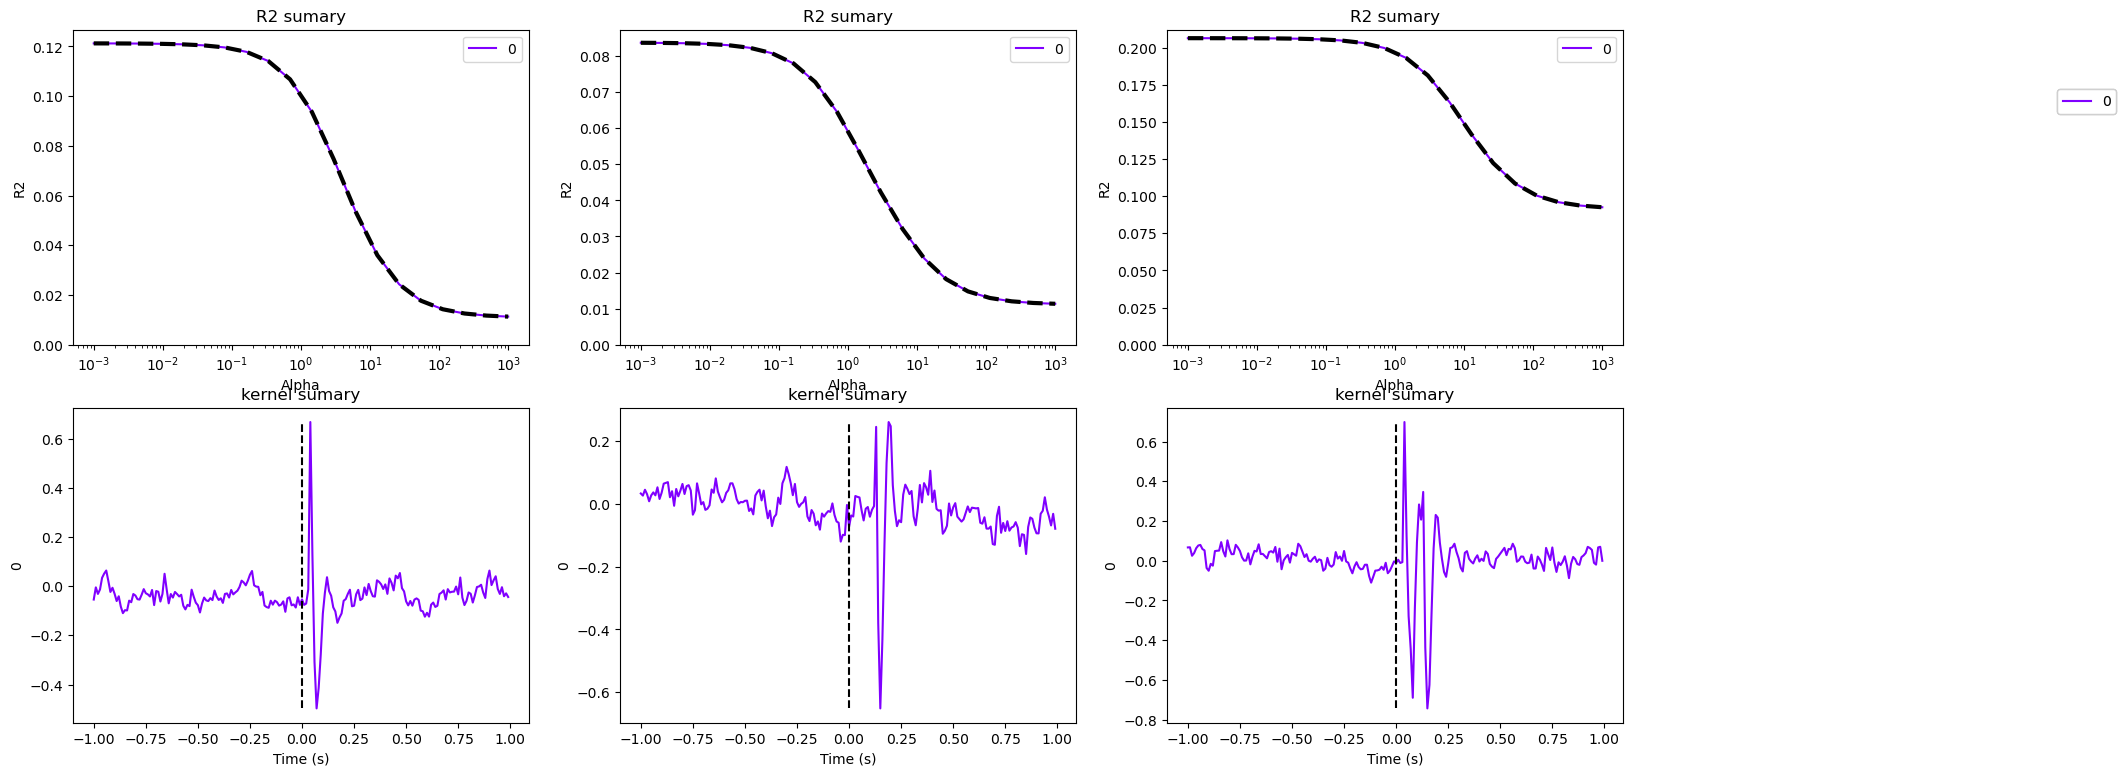

In [2248]:
fig, ax = plt.subplots(2,3, figsize = (20,9))
trf1.plot_kernel(figax = (fig, ax[1,0]))
trf2.plot_kernel(figax = (fig, ax[1,1]))
trf12.plot_kernel(figax = (fig, ax[1,2]))
trf1.plot_score(figax = (fig, ax[0,0]))
trf2.plot_score(figax = (fig, ax[0,1]))
trf12.plot_score(figax = (fig, ax[0,2]))
for i in range(3):
    ax[0,i].set_ylim([0,None])

(-1.0, 1.0)

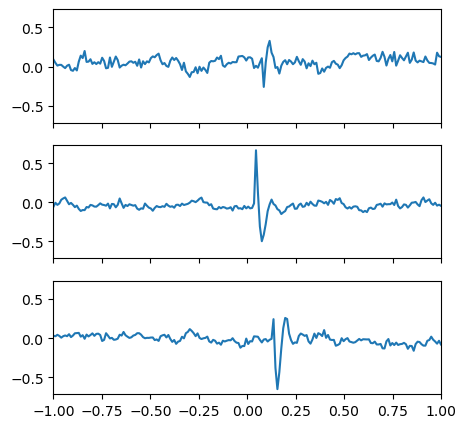

In [2249]:
fig,ax = plt.subplots(3,figsize = (5,5), sharey = True, sharex = True)

kernel_time = np.linspace(tmin, tmax,int((tmax-tmin)*fs))
alpha_kernel = int(np.mean([trf1.get_best_alpha(),trf2.get_best_alpha(),trf12.get_best_alpha()]))

ax[0].plot(kernel_time,scale((trf12.get_coef()[:,0,0,alpha_kernel] - trf1.get_coef()[:,0,0,alpha_kernel] - trf2.get_coef()[:,0,0,alpha_kernel]) ** 1, with_mean = False, with_std = False))
ax[1].plot(kernel_time,scale(trf1.get_coef()[:,0,0,alpha_kernel] ** 1, with_mean = False, with_std = False))
ax[2].plot(kernel_time,scale(trf2.get_coef()[:,0,0,alpha_kernel] ** 1, with_mean = False, with_std = False))
ax[0].set_xlim([-1,1])


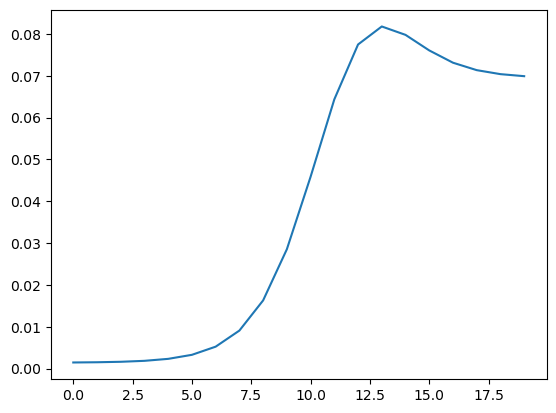

In [2251]:
plt.plot(scores12_trf - scores1_trf - scores2_trf)